# Demonstration of pyQ3 python wrapper for DEW-ENKI-EQ3-EQ6 aqueous speciation calculations - TUTORIAL 4

First import the required packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyQ3

## Reaction of a harzburgite with water at 350$^\circ$C
In this calculation we will equilibrate a fluid with a olivine + opx + magnetite assemblage, then allow the resulting fluid to react with the same assemblage.

First, create an instance of the default system

In [2]:
dew_system = pyQ3.System()

Set up the fluid. Let fO$_2$ be set by equilibrium with magnetite

In [3]:
molalities = {'NA+':0.05,
              'CL-':0.05}
mineral_eq = {'H4SIO4(AQ)':['ORTHOPYROXENE(SS)','ENSTATITE_OR'],
              'MG+2':['OLIVINE(SS)','FORSTERITE'],
              'FE+2':['OLIVINE(SS)','FAYALITE'],
              'O2(G)':'MAGNETITE'}
solid_solutions = {'OLIVINE(SS)':{'FORSTERITE':0.9, 'FAYALITE':0.1},
                   'ORTHOPYROXENE(SS)':{'ENSTATITE_OR':0.8,'FERROSILITE':0.2}}
T = 350.0 + 273.15
P = 10000.0

Run the EQ3 calculation to generate a fluid:

In [4]:
dew_fluid = pyQ3.Fluid(dew_system, T, P, molalities=molalities, mineral_eq=mineral_eq, solid_solutions=solid_solutions, uacion='NA+')

/Users/simonmatthews/opt/anaconda3/lib/python3.7/site-packages/pyQ3/output.py:150: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ss_info = pd.Series()


Set up the EQ6 calculation. Each reactant must be listed, with the number of moles that will be added during the reaction. If the reactant is a solid solution then its composition must be given also.

In [5]:
reactants = [{'reactant': 'OLIVINE(SS)',
              'moles': 2.0,
              'composition':{'FORSTERITE':0.9,'FAYALITE':0.1}},
             {'reactant': 'ORTHOPYROXENE(SS)',
              'moles': 2.0,
              'composition':{'ENSTATITE_OR':0.8,'FERROSILITE':0.2}},
             {'reactant': 'MAGNETITE',
              'moles': 0.2}]

Now generate the reaction. When creating an instance of the Reaction class the following things happen:
1. If the reaction is being performed at a different temperature or pressure than the fluid was generated at, then a new version of DATA0 will be created, and EQPT run.
2. The EQ6 input file will be generated, using the pickup file generated by EQ3 when the fluid was created. Since it needs the EQ3 generated pickup file, the fluid must be regenerated everytime you want to re-run the EQ6 calculation.
3. The EQ6 executable is copied into the working directory and run. The EQ6 executable is then removed.
4. The results (from the output and tab files) are read, and the results are stored in class attributes. More results are stored within in Reaction.output, but the most useful ones can be accessed more directly, as shown below.

In this case we run the calculation in titration mode, but we could also have run it in closed-system mode (the default choice).

In [6]:
dew_reaction = pyQ3.Reaction(dew_fluid, T, P, reactants, calculation_mode='titration')

We can inspect how the pH varied throughout the reaction. Notice the first entry is discarded, mostly out of convenience for plotting.

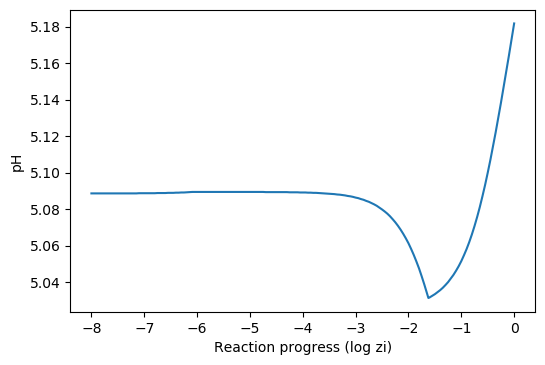

In [7]:
f,a = plt.subplots(dpi=100)
a.plot(dew_reaction.logzi[1:], dew_reaction.pH[1:])
a.set_xlabel('Reaction progress (log zi)')
a.set_ylabel('pH')
plt.show()

In this case the pH changed very little. We can also see how the elemental budget in the fluid changed during the reaction:

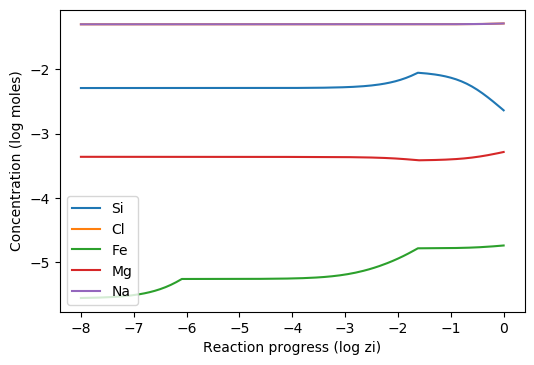

In [8]:
f,a = plt.subplots(dpi=100)
for el in list(dew_reaction.elements.columns):
    a.plot(dew_reaction.elements.index[1:], dew_reaction.elements[el].iloc[1:], label=el)
a.legend()
a.set_xlabel('Reaction progress (log zi)')
a.set_ylabel('Concentration (log moles)')
plt.show()

Next we can see which phases precipated during reaction:

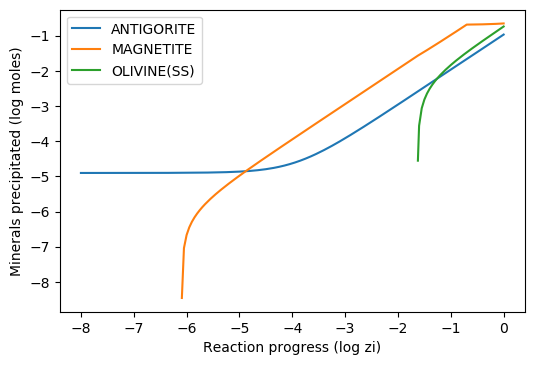

In [9]:
f,a = plt.subplots(dpi=100)
for mi in list(dew_reaction.minerals.columns):
    a.plot(dew_reaction.minerals.index[1:], dew_reaction.minerals[mi].iloc[1:], label=mi)
a.legend()
a.set_xlabel('Reaction progress (log zi)')
a.set_ylabel('Minerals precipitated (log moles)')
plt.show()

Olivine is precipitating, but what is its composition?

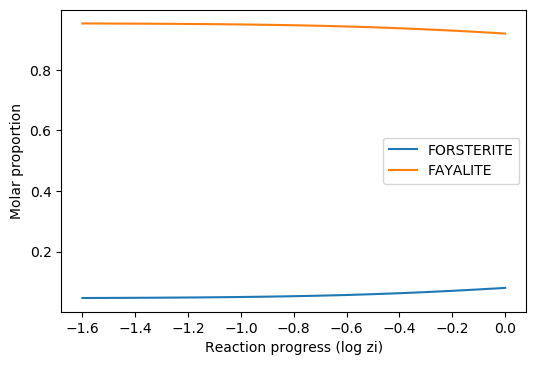

In [10]:
f,a = plt.subplots(dpi=100)
for mi in list(dew_reaction.solid_solutions.columns):
    a.plot(dew_reaction.solid_solutions.index[1:], dew_reaction.solid_solutions[mi].iloc[1:], label=mi)
a.legend()
a.set_xlabel('Reaction progress (log zi)')
a.set_ylabel('Molar proportion')
plt.show()

Maybe we are interested specifically in how Mg is complexed in this fluid. We can also extract this information from the results:

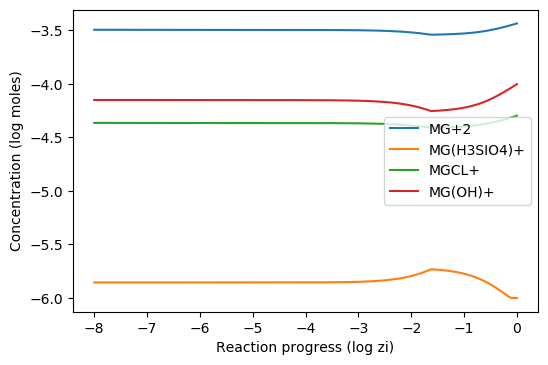

In [11]:
f,a = plt.subplots(dpi=100)
for sp in list(dew_reaction.species_concs.columns):
    if 'MG' in sp:
        a.plot(dew_reaction.species_concs.index[1:], dew_reaction.species_concs[sp].iloc[1:], label=sp)
a.legend()
a.set_xlabel('Reaction progress (log zi)')
a.set_ylabel('Concentration (log moles)')
plt.show()

To see all the options available when creating a reaction, you can view the documentation like this:

In [13]:
pyQ3.Reaction?

Init signature:
pyQ3.Reaction(
    fluid,
    T,
    P,
    reactants,
    dT=0.0,
    calculation_mode='closed',
    zimax=1.0,
    eq6_executable_name=None,
    eq3_working_directory='working',
    eqpt_working_directory='working',
    eq6_working_directory='working',
    eqpt_executable_name=None,
    dummy_temperature=500.0,
)
Docstring:     
Class for enabling EQ6 calculations. The working directory will be the same as used when
generating the Fluid.

Attributes
----------

Parameters
----------
fluid : pyQ3.Fluid object
    The fluid object to react with
t : float
    The temperature (K)
p : float
    The pressure (bars)
reactants : list of dicts
    The reactants for the calculation. The dicts should be formatted with keys and values:
    - reactant (str)
      The name of the mineral
    - moles (float)
      The moles in the reaction (relative to 1 kg of water)
    - composition (dict)
      If the mineral is a solid solution this must be provided. Each endmember should be giv